In [ ]:
import rioxarray as rxr
import xarray as xr
import glob
import pandas as pd
import os
import numpy as np

# NDVI a 0.05 grados

In [1]:

# Especifica el patrón para encontrar los archivos .tif
ruta = "E:/Climaticas/ICESI/ICESI/output/data/climate/raw_data/ndvi/*.tif"
tif_files = glob.glob(ruta)
print("Archivos encontrados:", tif_files)


NameError: name 'glob' is not defined

In [ ]:


data_arrays = []

for file in tif_files:
    # Extraer el nombre base del archivo
    basename = os.path.basename(file)
    # La estructura del nombre es: 
    # AVHRR-Land_v005_AVH13C1_NOAA-19_20130101_c20170408020753
    # Suponiendo que la fecha se encuentra en la quinta parte (índice 4)
    partes = basename.split('_')
    date_str = partes[4]  # '20130101'
    # Convertir a objeto datetime
    fecha = pd.to_datetime(date_str, format="%Y%m%d")
    
    # Abrir el archivo .tif con rioxarray
    da = rxr.open_rasterio(file)
    # Si da tiene dimensiones (band, y, x), se añade una dimensión 'time'
    da = da.expand_dims(time=[fecha])
    
    data_arrays.append(da)

# Concatenar todos los DataArrays a lo largo de la dimensión 'time'
ds_combined = xr.concat(data_arrays, dim="time")
print(ds_combined)
 

ds_combined = ds_combined.where(ds_combined != -9999, np.nan)

ds_combined = ds_combined.squeeze('band', drop=True)
ds_combined[0,:,:].plot()


<xarray.DataArray (time: 4333, band: 1, y: 40, x: 36)> Size: 12MB
array([[[[-9999, -9999, -9999, ..., -9999, -9999, -9999],
         [-9999, -9999, -9999, ..., -9999, -9999, -9999],
         [-9999, -9999, -9999, ..., -9999, -9999, -9999],
         ...,
         [-9999, -9999,  4207, ..., -9999, -9999, -9999],
         [-9999, -9999, -9999, ..., -9999, -9999, -9999],
         [-9999, -9999, -9999, ..., -9999, -9999, -9999]]],


       [[[-9999, -9999, -9999, ..., -9999, -9999, -9999],
         [-9999, -9999, -9999, ..., -9999, -9999, -9999],
         [-9999, -9999, -9999, ..., -9999, -9999, -9999],
         ...,
         [-9999, -9999,   618, ..., -9999, -9999, -9999],
         [-9999, -9999, -9999, ..., -9999, -9999, -9999],
         [-9999, -9999, -9999, ..., -9999, -9999, -9999]]],


       [[[-9999, -9999, -9999, ..., -9999, -9999, -9999],
         [-9999, -9999, -9999, ..., -9999, -9999, -9999],
...
         [-9999, -9999, -9999, ..., -9999, -9999, -9999]]],


       [[[-9999, -99

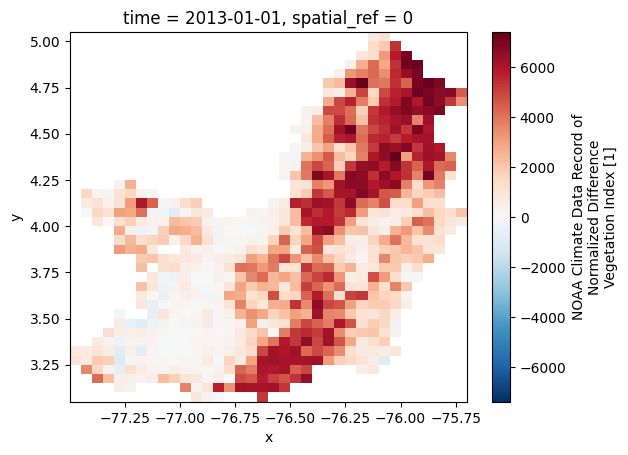

In [ ]:
ds_combined[0,:,:].plot()

# Temperatura maxima

In [ ]:
# Define el patrón para encontrar los archivos .nc
ruta = "E:/Climaticas/ICESI/ICESI/output/data/climate/raw_data/temperature_max/*.nc"

nc_files = glob.glob(ruta)
print("Cantidad de archivos encontrados:", len(nc_files))


ds_list = []

for file in nc_files:
    ds = xr.open_dataset(file, chunks={})
    # Verifica que el dataset tenga la coordenada "time"
    if "time" not in ds.coords:
        raise ValueError(f"El archivo {file} no tiene la coordenada 'time'")
    ds_list.append(ds)


# Concatenar todos los datasets a lo largo de la dimensión "time"
ds_temp_max = xr.concat(ds_list, dim="time")
ds_temp_max =ds_temp_max.Temperature_Air_2m_Max_24h
print(ds_temp_max)


Cantidad de archivos encontrados: 4383
<xarray.Dataset> Size: 6MB
Dimensions:                     (time: 4383, lat: 20, lon: 17)
Coordinates:
  * time                        (time) datetime64[ns] 35kB 2013-01-01 ... 202...
  * lon                         (lon) float64 136B -77.4 -77.3 ... -75.9 -75.8
  * lat                         (lat) float64 160B 5.0 4.9 4.8 ... 3.3 3.2 3.1
Data variables:
    Temperature_Air_2m_Max_24h  (time, lat, lon) float32 6MB dask.array<chunksize=(1, 20, 17), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.2 (http://mpimet.mpg.de/...
    history:      Fri Mar 12 14:55:07 2021: cdo splitday /archive/ESG/wit015/...
    Conventions:  CF-1.7
    CDO:          Climate Data Operators version 1.9.2 (http://mpimet.mpg.de/...


# Match por date y resample

In [47]:
common_dates = np.intersect1d(ds_combined.time, ds_temp_max.time)

# Seleccionamos solo las fechas comunes en cada dataset
ds_high_common = ds_combined.sel(time=common_dates)
ds_coarse_common = ds_temp_max.sel(time=common_dates)

In [55]:
ds_high_common = ds_high_common.rename({"x": "lon", "y": "lat"})
ds_high_regridded = ds_high_common.interp(
    lon=ds_coarse_common.lon, 
    lat=ds_coarse_common.lat,
    method="linear"
)


# Ahora ds_high_regridded y ds_coarse_common tienen:
# - Las mismas fechas (dimensión "time")
# - La misma malla espacial (coordenadas "lat" y "lon")

print(ds_high_regridded)
print(ds_coarse_common)

<xarray.DataArray (time: 4333, lat: 20, lon: 17)> Size: 12MB
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
          6.36397531e+03,             nan,             nan],
        [            nan,             nan,             nan, ...,
          5.46788467e+03,             nan,             nan],
        ...,
        [ 1.05519181e+03,  1.32026874e+02, -4.92545929e+01, ...,
                     nan,             nan,             nan],
        [            nan,  5.90195678e+02,  6.38293207e+02, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,

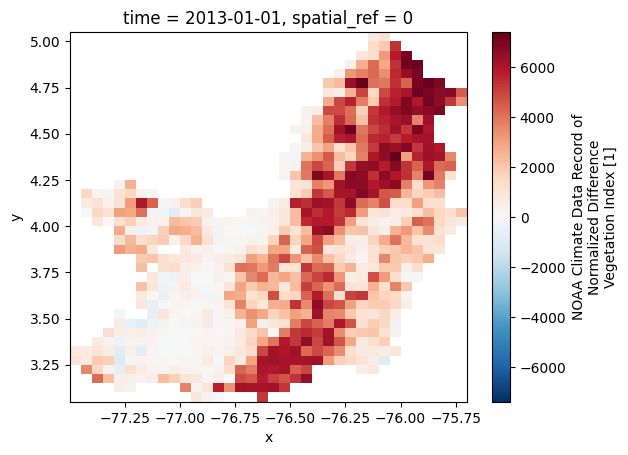

In [59]:
ds_combined[0,:,:].plot()

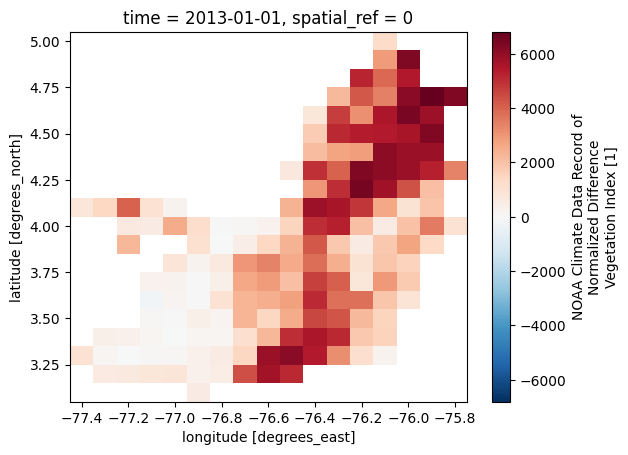

In [58]:
ds_high_regridded[0,:,:].plot()

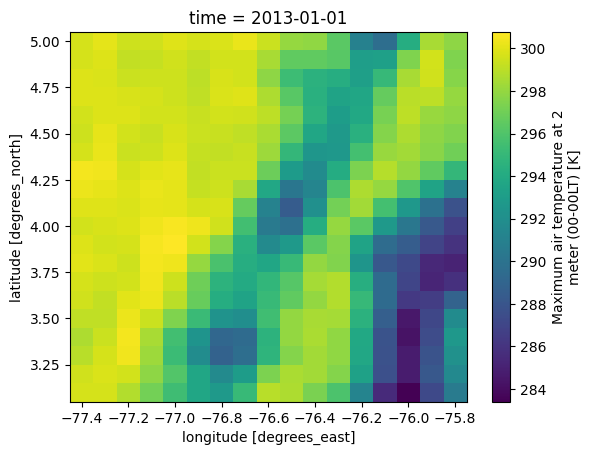

In [91]:
ds_coarse_common[0,:,:].plot()

# Agregación por semana epidemiologica


In [62]:

def start_of_epi_year(Y: int) -> pd.Timestamp:
    """
    Devuelve el domingo que define el inicio de la semana 1 del año Y,
    según la regla:
      - La 'semana 1' comienza en el primer domingo entre
        29 de diciembre de Y-1 y 4 de enero de Y.
    """
    dec29 = pd.Timestamp(Y - 1, 12, 29)
    jan4  = pd.Timestamp(Y, 1, 4)
    # Día de la semana (lunes=0 ... domingo=6)
    w = dec29.weekday()
    # Offset para encontrar el siguiente domingo a partir de dec29
    offset = (6 - w) % 7
    first_sunday = dec29 + pd.Timedelta(days=offset)

    # Si por algún motivo ese domingo rebasara el 4 de enero de Y, retrocedemos 7 días
    if first_sunday > jan4:
        first_sunday -= pd.Timedelta(days=7)

    return first_sunday


def get_epi_year_week(date: pd.Timestamp) -> tuple[int, int]:
    """
    Dada una fecha (Timestamp), retorna (epi_year, epi_week)
    según la convención:
      - Semanas van de domingo a sábado.
      - La semana 1 de un año Y empieza en start_of_epi_year(Y).
      - Puede existir semana 53 si sobran >=4 días al final del año.
    """
    # (1) Encontrar el domingo de la semana que contiene 'date'.
    #     weekday(): lunes=0, ..., domingo=6
    offset = (date.weekday() + 1) % 7  # 0 si es domingo, 1 si es lunes...
    sunday_of_date = date - pd.Timedelta(days=offset)

    # (2) Decidir si este domingo corresponde al año sunday_of_date.year o al siguiente
    #     - Comparamos con start_of_epi_year(...) del "año + 1"
    candidate_next_year_start = start_of_epi_year(sunday_of_date.year + 1)

    if sunday_of_date < candidate_next_year_start:
        # Está dentro del año epidemiológico actual
        epi_year = sunday_of_date.year
    else:
        # Pertenece al siguiente
        epi_year = sunday_of_date.year + 1

    # (3) Calcular cuántas semanas han pasado desde el inicio de epi_year
    start_of_year = start_of_epi_year(epi_year)
    delta_days = (sunday_of_date - start_of_year).days
    epi_week = (delta_days // 7) + 1  # semana 1, 2, 3, etc.

    return epi_year, epi_week

In [66]:
# Calcular la semana epidemiológica para cada fecha y agregarla como coordenada
epi_weeks = []
for t in ds_high_regridded.time.values:
    t_pd = pd.Timestamp(t)
    epi_year, epi_week = get_epi_year_week(t_pd)
    # Formateamos como "AÑO-SEMA" (ej.: "2013-01")
    epi_weeks.append(f"{epi_year}-{epi_week:02d}")

da = ds_high_regridded.assign_coords(epi_week=("time", epi_weeks))

# Agrupar por semana epidemiológica y calcular el máximo para cada grupo
da_NDVI_max = da.groupby("epi_week").max("time", skipna=True)

print(da_NDVI_max)

<xarray.DataArray (epi_week: 622, lat: 20, lon: 17)> Size: 2MB
array([[[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
         6386.25367871,           nan,           nan],
        [          nan,           nan,           nan, ...,
         6199.51600482,           nan,           nan],
        ...,
        [1689.03162361, 2321.73589375, 1112.52193117, ...,
                   nan,           nan,           nan],
        [          nan,  660.07122966,  804.48934914, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]],

       [[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
         6927.54431977,           nan,           nan],
        [ 

In [68]:
# Calcular la semana epidemiológica para cada fecha y agregarla como coordenada
epi_weeks = []
for t in ds_coarse_common.time.values:
    t_pd = pd.Timestamp(t)
    epi_year, epi_week = get_epi_year_week(t_pd)
    # Formateamos como "AÑO-SEMA" (ej.: "2013-01")
    epi_weeks.append(f"{epi_year}-{epi_week:02d}")

da = ds_coarse_common.assign_coords(epi_week=("time", epi_weeks))

# Agrupar por semana epidemiológica y calcular el máximo para cada grupo
da_tmax_mean = da.groupby("epi_week").mean("time", skipna=True)

print(da_tmax_mean)

<xarray.DataArray 'Temperature_Air_2m_Max_24h' (epi_week: 622, lat: 20, lon: 17)> Size: 846kB
dask.array<stack, shape=(622, 20, 17), dtype=float32, chunksize=(1, 20, 17), chunktype=numpy.ndarray>
Coordinates:
  * lon       (lon) float64 136B -77.4 -77.3 -77.2 -77.1 ... -76.0 -75.9 -75.8
  * lat       (lat) float64 160B 5.0 4.9 4.8 4.7 4.6 4.5 ... 3.5 3.4 3.3 3.2 3.1
  * epi_week  (epi_week) object 5kB '2013-01' '2013-02' ... '2024-52' '2025-01'
Attributes:
    long_name:             Maximum air temperature at 2 meter (00-00LT)
    units:                 K
    temporal_aggregation:  Max 00-00LT


In [ ]:
da_pixel = da_tmax_mean.stack(pixel=("lat", "lon"))
da_transposed = da_pixel.transpose("pixel", "epi_week")
y = da_transposed.values.flatten()

In [106]:
y

array([299.6697 , 300.02884, 299.86105, ..., 290.35822, 290.20782,
       290.10886], shape=(211480,), dtype=float32)

In [96]:
da_pixel_NDVI = da_NDVI_max.stack(pixel=("lat", "lon"))
da_NDVI_transposed = da_pixel_NDVI.transpose("pixel", "epi_week")
X = da_NDVI_transposed.values.flatten()

In [79]:
pip install bayesian-optimization

Note: you may need to restart the kernel to use updated packages.


In [80]:
import numpy as np
import pandas as pd
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# modelación con xgbost 

In [97]:
# Dividir en conjunto de entrenamiento y validación
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
# Asegurarse de que X_train y X_valid sean 2D
if X_train.ndim == 1:
    X_train = X_train.reshape(-1, 1)
if X_valid.ndim == 1:
    X_valid = X_valid.reshape(-1, 1)

In [98]:
# Para X_train y y_train:
mask_train = ~np.isnan(y_train) & ~np.isnan(X_train).any(axis=1)
X_train = X_train[mask_train]
y_train = y_train[mask_train]

# Para X_valid y y_valid:
mask_valid = ~np.isnan(y_valid) & ~np.isnan(X_valid).any(axis=1)
X_valid = X_valid[mask_valid]
y_valid = y_valid[mask_valid]

In [105]:
y_train

array([299.53717, 291.5256 , 296.68124, ..., 296.50238, 294.43707,
       292.5549 ], shape=(83650,), dtype=float32)

In [99]:

import numpy as np
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error

# Asegúrate de que tus datos tengan la forma adecuada:
if X_train.ndim == 1:
    X_train = X_train.reshape(-1, 1)
if X_valid.ndim == 1:
    X_valid = X_valid.reshape(-1, 1)

def xgb_cv(max_depth, learning_rate, min_child_weight, subsample, colsample_bytree):
    # Configurar parámetros
    params = {
        'objective': 'reg:squarederror',
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'min_child_weight': min_child_weight,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'seed': 42,
    }
    
    # Preparar los DMatrix para XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)
    
    # Entrenar el modelo
    model = xgb.train(params, dtrain, num_boost_round=100, verbose_eval=False)
    
    # Predecir y calcular el RMSE
    y_pred = model.predict(dvalid)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    
    # Retornamos el negativo de RMSE (para maximizarlo)
    return -rmse

# Definir el espacio de hiperparámetros a explorar
pbounds = {
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3),
    'min_child_weight': (1, 10),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0)
}

optimizer = BayesianOptimization(
    f=xgb_cv,
    pbounds=pbounds,
    random_state=42,
)

optimizer.maximize(init_points=3, n_iter=50)

# Imprimir el mejor resultado encontrado
print("Mejor resultado:", optimizer.max)



|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------
| 1         | -3.518    | 0.6873    | 0.2857    | 8.124     | 6.388     | 0.578     |
| 2         | -3.519    | 0.578     | 0.02684   | 9.063     | 6.41      | 0.854     |
| 3         | -3.518    | 0.5103    | 0.2913    | 8.827     | 2.911     | 0.5909    |
| 4         | -3.517    | 0.5779    | 0.0806    | 8.895     | 2.884     | 0.5363    |
| 5         | -3.517    | 0.5022    | 0.08843   | 9.064     | 2.918     | 0.5324    |
| 6         | -3.521    | 0.7398    | 0.02238   | 8.977     | 2.845     | 0.7157    |
| 7         | -3.517    | 0.5819    | 0.1902    | 9.067     | 2.857     | 0.564     |
| 8         | -3.514    | 0.9038    | 0.06098   | 5.217     | 3.42      | 0.8629    |
| 9         | -3.516    | 0.9176    | 0.124     | 5.226     | 3.591     | 0.8398    |
| 10        | -3.518    | 0.5377    | 0.2455    | 6.26

In [100]:
# 1. Concatenar los datos de entrenamiento y validación
X_full = np.vstack([X_train, X_valid])
y_full = np.concatenate([y_train, y_valid])

# 2. Crear el DMatrix para todos los datos
dfull = xgb.DMatrix(X_full, label=y_full)

# 3. Definir los parámetros del modelo usando los hiperparámetros óptimos obtenidos
# Suponiendo que optimizer.max['params'] contiene los mejores hiperparámetros:
params_full = {
    'objective': 'reg:squarederror',
    'max_depth': int(optimizer.max['params']['max_depth']),
    'learning_rate': optimizer.max['params']['learning_rate'],
    'min_child_weight': optimizer.max['params']['min_child_weight'],
    'subsample': optimizer.max['params']['subsample'],
    'colsample_bytree': optimizer.max['params']['colsample_bytree'],
    'seed': 42,
}

# 4. Entrenar el modelo en el conjunto completo
model_full = xgb.train(params_full, dfull, num_boost_round=100, verbose_eval=True)


In [103]:
import matplotlib.pyplot as plt

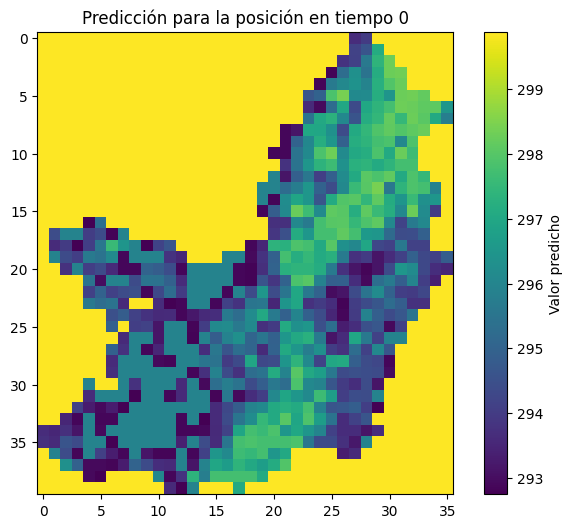

In [104]:

# 1. Extraer la capa en tiempo deseada (por ejemplo, la posición 0)
time_index = 0
data_slice = ds_combined.isel(time=time_index)

# 2. Aplanar la capa para formar una matriz (n_samples, n_features)
# Aquí n_features es 1 (una sola variable predictora)
X_new = data_slice.values.flatten().reshape(-1, 1)

# 3. Preparar la matriz para XGBoost
dnew = xgb.DMatrix(X_new)

# 4. Predecir con el modelo
y_pred_new = model_full.predict(dnew)

# 5. Reestructurar la predicción a la forma espacial original
prediction_map = y_pred_new.reshape(data_slice.shape)

# 6. Graficar el resultado
plt.figure(figsize=(8, 6))
plt.imshow(prediction_map, cmap='viridis')
plt.title("Predicción para la posición en tiempo {}".format(time_index))
plt.colorbar(label="Valor predicho")
plt.show()

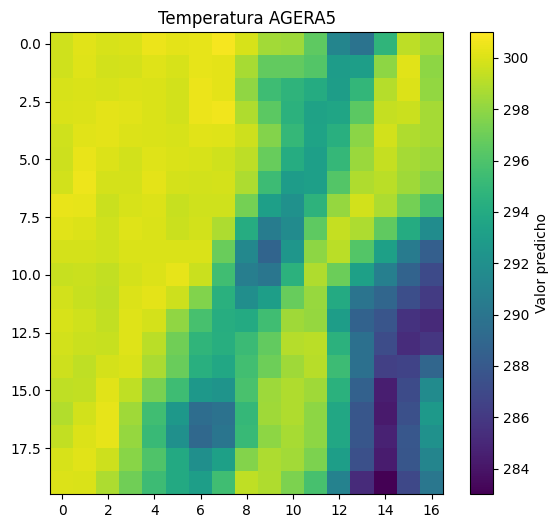

In [131]:

plt.figure(figsize=(7, 6))
plt.imshow(da_tmax_mean[0, :, :], cmap='viridis', vmin=283, vmax=301)
plt.title("Temperatura AGERA5")
plt.colorbar(label="Valor predicho")
plt.show()


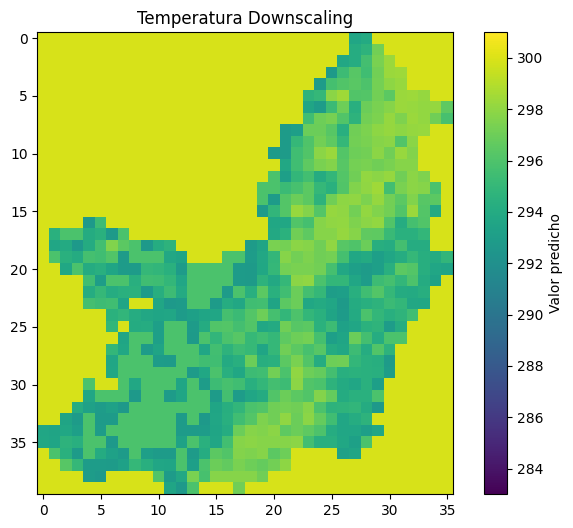

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf

# Supongamos que 'prediction_map' es el resultado de la predicción con forma (ny, nx)
ny, nx = prediction_map.shape

# Crear las coordenadas de la malla (por ejemplo, índices de filas y columnas)
x = np.arange(nx)
y = np.arange(ny)
X, Y = np.meshgrid(x, y)

# Aplanar las coordenadas y el mapa de predicción
X_flat = X.flatten()
Y_flat = Y.flatten()
Z_flat = prediction_map.flatten()

# Configurar la interpolación RBF
# Puedes probar diferentes funciones ('multiquadric', 'inverse', 'gaussian', etc.) y parámetros de suavizado
rbf_interpolator = Rbf(X_flat, Y_flat, Z_flat, function='multiquadric', smooth=0)

# Evaluar el interpolador en la malla original (o en una malla más densa, si lo prefieres)
Z_rbf = rbf_interpolator(X, Y)

# Graficar el resultado
plt.figure(figsize=(8, 6))
plt.imshow(Z_rbf, cmap='viridis',vmin=283, vmax=301)
plt.title("Temperatura Downscaling")
plt.colorbar(label="Valor predicho")
plt.show()






In [ ]:

import numpy as np
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error

# Asegúrate de que tus datos tengan la forma adecuada:
if X_train.ndim == 1:
    X_train = X_train.reshape(-1, 1)
if X_valid.ndim == 1:
    X_valid = X_valid.reshape(-1, 1)

def xgb_cv(max_depth, learning_rate, min_child_weight, subsample, colsample_bytree):
    # Configurar parámetros
    params = {
        'objective': 'reg:squarederror',
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'min_child_weight': min_child_weight,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'seed': 42,
    }
    
    # Preparar los DMatrix para XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)
    
    # Entrenar el modelo
    model = xgb.train(params, dtrain, num_boost_round=100, verbose_eval=False)
    
    # Predecir y calcular el RMSE
    y_pred = model.predict(dvalid)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    
    # Retornamos el negativo de RMSE (para maximizarlo)
    return -rmse

# Definir el espacio de hiperparámetros a explorar
pbounds = {
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3),
    'min_child_weight': (1, 10),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0)
}

optimizer = BayesianOptimization(
    f=xgb_cv,
    pbounds=pbounds,
    random_state=42,
)

optimizer.maximize(init_points=3, n_iter=50)

# Imprimir el mejor resultado encontrado
print("Mejor resultado:", optimizer.max)



|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------
| 1         | -3.518    | 0.6873    | 0.2857    | 8.124     | 6.388     | 0.578     |
| 2         | -3.519    | 0.578     | 0.02684   | 9.063     | 6.41      | 0.854     |
| 3         | -3.518    | 0.5103    | 0.2913    | 8.827     | 2.911     | 0.5909    |
| 4         | -3.517    | 0.5779    | 0.0806    | 8.895     | 2.884     | 0.5363    |
| 5         | -3.517    | 0.5022    | 0.08843   | 9.064     | 2.918     | 0.5324    |
| 6         | -3.521    | 0.7398    | 0.02238   | 8.977     | 2.845     | 0.7157    |
| 7         | -3.517    | 0.5819    | 0.1902    | 9.067     | 2.857     | 0.564     |
| 8         | -3.514    | 0.9038    | 0.06098   | 5.217     | 3.42      | 0.8629    |
| 9         | -3.516    | 0.9176    | 0.124     | 5.226     | 3.591     | 0.8398    |
| 10        | -3.518    | 0.5377    | 0.2455    | 6.26

In [6]:
import xarray as xr
import glob

# Especifica el patrón que abarque tus 5 archivos .nc 
# (modifica la ruta y el patrón si es necesario)

import glob

path = "E:/data_climatica/relative_humidity/*.nc"
archivos = glob.glob(path)
print("Archivos encontrados:", archivos)

Archivos encontrados: ['E:/data_climatica/relative_humidity\\relative_humidity_2014_01.nc', 'E:/data_climatica/relative_humidity\\relative_humidity_2014_02.nc', 'E:/data_climatica/relative_humidity\\relative_humidity_2014_03.nc', 'E:/data_climatica/relative_humidity\\relative_humidity_2014_04.nc', 'E:/data_climatica/relative_humidity\\relative_humidity_2014_05.nc', 'E:/data_climatica/relative_humidity\\relative_humidity_2014_06.nc', 'E:/data_climatica/relative_humidity\\relative_humidity_2014_07.nc', 'E:/data_climatica/relative_humidity\\relative_humidity_2014_08.nc', 'E:/data_climatica/relative_humidity\\relative_humidity_2014_09.nc', 'E:/data_climatica/relative_humidity\\relative_humidity_2014_10.nc', 'E:/data_climatica/relative_humidity\\relative_humidity_2014_11.nc', 'E:/data_climatica/relative_humidity\\relative_humidity_2014_12.nc', 'E:/data_climatica/relative_humidity\\relative_humidity_2015_01.nc', 'E:/data_climatica/relative_humidity\\relative_humidity_2015_02.nc', 'E:/data_cl

In [14]:
ds = xr.open_dataset(archivos[0], engine='scipy')
print(ds)

TypeError: Error: E:\data_climatica\relative_humidity\relative_humidity_2014_01.nc is not a valid NetCDF 3 file
            If this is a NetCDF4 file, you may need to install the
            netcdf4 library, e.g.,

            $ pip install netcdf4
            